# Trabajo práctico Aprendizaje de Máquina - *NASA Exoplanet Archive*
*Pablo Brahim - Kevin Pennington*

## Introducción al conjunto de datos KOI Q1–Q17 DR 25

---



El conjunto de datos utilizado en este trabajo corresponde a la **tabla de objetos de interés Kepler (Kepler Object-of-Interest - KOI) del Data Release 25 (DR 25)**, disponible públicamente en el [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/). Esta tabla contiene el resultado del análisis automatizado de curvas de luz obtenidas por el telescopio espacial **Kepler**, que tuvo como objetivo principal la detección de exoplanetas mediante el método de tránsito.

Durante su misión, Kepler monitoreó de forma continua la luminosidad de más de 150,000 estrellas. Variaciones periódicas en el brillo de una estrella pueden indicar que un objeto (como un planeta) pasa frente a ella, generando una pequeña disminución en la intensidad observada. Estas señales, conocidas como **eventos de cruce de umbral** (*Threshold Crossing Events*, o TCEs), son clasificadas y evaluadas en busca de patrones consistentes con un tránsito planetario.

En el DR 25, el análisis se realizó de forma completamente automatizada mediante un sistema denominado **Robovetter**, que aplica una serie de pruebas y métricas para determinar si una señal es **similar a un tránsito** (*transit-like*) o no. Aquellas consideradas transit-like reciben un número KOI y son sometidas a pruebas adicionales para descartar falsas detecciones, como eclipses estelares, errores instrumentales o señales contaminadas por objetos cercanos.

Cada KOI es finalmente etiquetado con una **disposición** (*disposition*), que puede ser:
- **PC** (*Planet Candidate*): candidato a planeta.
- **FP** (*False Positive*): falso positivo.
- (implícitamente) **Not transit-like**: señales que no fueron promovidas a KOI por no parecerse a un tránsito.

Adicionalmente, se incluye un parámetro llamado **Disposition Score**, un valor entre 0 y 1 que refleja el nivel de confianza del sistema en la disposición asignada. Valores cercanos a 1 indican alta confianza en que se trata de un planeta candidato, mientras que valores cercanos a 0 reflejan alta confianza en que es un falso positivo.

Es importante destacar que este catálogo fue construido con fines estadísticos y de uniformidad para estudios de tasa de ocurrencia planetaria. Por ello, algunas disposiciones pueden diferir de catálogos anteriores más conservadores, priorizándose en este caso la **confiabilidad global del conjunto por sobre la revisión manual individual de cada sistema**.

Este dataset incluye parámetros orbitales, características de la curva de luz, y propiedades estimadas de la estrella anfitriona y del posible planeta, calculados principalmente mediante métodos de ajuste como el muestreo Monte Carlo de cadenas de Markov (MCMC).


In [2]:
# from google.colab import files

# uploaded = files.upload()

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import MinMaxScaler

In [108]:
df = pd.read_csv("dr25.tab", sep="\t", header=53)
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,11446443,K00001.01,Kepler-1 b,CONFIRMED,CANDIDATE,0.811,0,0,0,0,...,-78.0,4.457,0.024,-0.024,0.964,0.038,-0.038,286.80847,49.316399,11.338
1,10666592,K00002.01,Kepler-2 b,CONFIRMED,CANDIDATE,1.000,0,1,0,0,...,-89.0,4.019,0.033,-0.027,1.952,0.099,-0.110,292.24728,47.969521,10.463
2,10748390,K00003.01,Kepler-3 b,CONFIRMED,CANDIDATE,0.913,0,0,0,0,...,-95.0,4.591,0.015,-0.036,0.763,0.028,-0.028,297.70935,48.080853,9.174
3,3861595,K00004.01,Kepler-1658 b,CONFIRMED,CANDIDATE,1.000,0,1,0,0,...,-114.0,3.657,0.270,-0.090,2.992,0.416,-0.971,294.35654,38.947380,11.432
4,8554498,K00005.01,NaN,CANDIDATE,CANDIDATE,1.000,0,0,0,0,...,-65.0,4.012,0.030,-0.030,1.787,0.132,-0.076,289.73972,44.647419,11.665


## Planteo del problema

En este trabajo vamos a plantear un problema de clasidicacion binaria: dados los atributos del KOI, buscamos predecir si se trata
de un candidato `CONFIRMED` o un `FALSE POSITIVE`.  En este aspecto destacan dos columnas `koi_disposition` y `koi_pdisposition`.
En la [documentación](https://exoplanetarchive.ipac.caltech.edu/applications/DocSet/index.html?doctree=/docs/docmenu.xml&startdoc=item_1_01) puede hallarse un detalle de cada columna.

La columna `koi_pdisposition` se trata de la disposicion

    "The pipeline flag that designates the most probable physical explanation of the KOI."
la fuente de esta clasificacion es automaticamente asignada por el Kepler pipeline, basado en alguna pruebas internas.

Mientras que `koi_disposition`
        
    "The category of this KOI from the Exoplanet Archive."
es el veredicto final de *NASA Exoplanet Archive*, que incluye revisiones manuales y estudios posteriores.
Representa la verdad autoritativa sobre el *label*. Esta categoria suele cambiar con el tiempo y los estudios.

Por tal motivo, el valor que buscamos predecir es el de la *disposición final* del *KOI*: `koi_disposition`

## EDA

### Target

Comenzamos por analizar la variable *target*, vemos que toma tres valores en este dataset:
`FALSE POSITIVE`, `CONFIRMED` y `CANDIDATE`.
No buscamos clasificar a `CANDIDATE` y, dada la naturaleza ambigua de este valor (se trata de objetos que aun no tienen veredicto final), es posible que sea necesario eliminar esas filas.

In [109]:
df.koi_disposition.value_counts()

koi_disposition
FALSE POSITIVE    3966
CONFIRMED         2728
CANDIDATE         1360
Name: count, dtype: int64

Dado que existe un gran numero de `CANDIDATE`s seria bueno intentar inputar algunos casos con los labels a predecir,
para intentar no dañar mucho el dataset.

Existe una variable `koi_score` que expresa la confianza en la clasificacion en el pipeline:
        
    A value between 0 and 1 that indicates the confidence in the KOI disposition.
    For CANDIDATEs, a higher value indicates more confidence in its disposition,
    while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition.

Esto no es una regla rigida, por lo que simplemente clasificar todos los `CANDIDATE` con puntaje alto a `CONFIRMED` y los `FALSE POSITIVE` de puntaje alto como `FALSE POSITIVE` puede ser contra producente.

Además podemos mirar como se relaciona la variable `koi_pdisposition` con el target

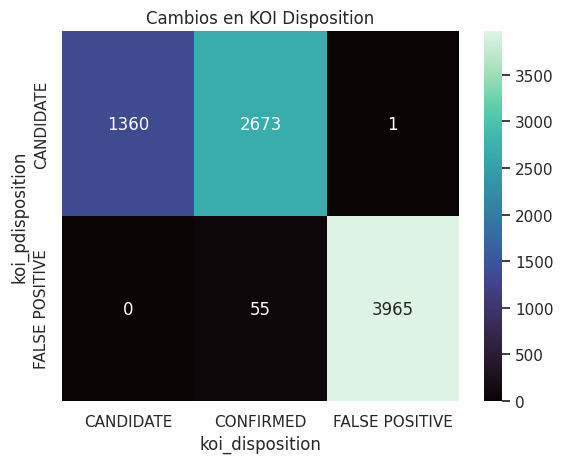

In [110]:
disposition_counts = pd.crosstab(
    df['koi_pdisposition'],
    df['koi_disposition'],
    margins=True,
    margins_name="Total"
)
sns.heatmap(
    pd.crosstab(df['koi_pdisposition'], df['koi_disposition']),
    annot=True, fmt='d', cmap='mako'
)
plt.title("Cambios en KOI Disposition")
plt.show()


Algunas conclusiones pueden sacarse en base a esta relacion:
    
* Es muy poco probable que un `FALSE POSITIVE` pase a confirmado `55/4020`
* o, equivalentemente, los casos `CONFIRMED` en la disposición final provienen de `CANDIDATOS` de la pipeline.
* reciprocamente, es extremadamente poco probable (1 solo caso) que un candidato de la pipeline, resulte `FALSO POSITIVO` (caveat: de aquellos que cambiaron de estado)

Podemos tomar esto para la inputacion de los `CANDIDATE` en el target, si además nos valemos del `koi_score`.
Podemos promover `CANDIDATE` a `CONFIRMED` cuando superen cierto umbral del score.

Miramos la distribucion `koi_score`

<Axes: xlabel='koi_score', ylabel='Count'>

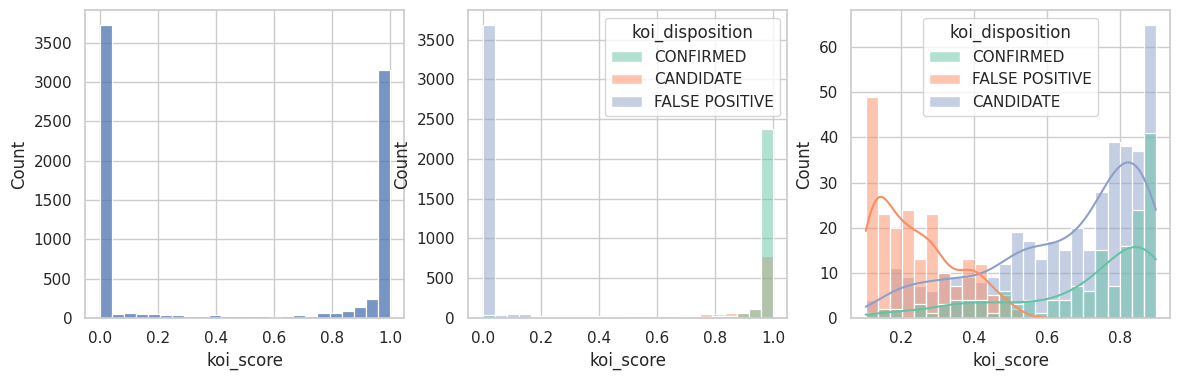

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.histplot(data=df, x='koi_score', bins=24, ax=axes[0])
sns.histplot(data=df, x='koi_score', bins=24, hue='koi_disposition', ax=axes[1], palette='Set2')
sns.histplot(
    data=df[(df["koi_score"] > 0.1) & (df["koi_score"] < 0.9)],
    x='koi_score',
    bins=24,
    hue='koi_disposition',
    ax=axes[2],
    palette='Set2',
    kde=True
)

En el ultimo histograma se muestra la distribucion del score, separada por la disposición final otrogada al KOI.
Los `FALSE POSITIVE` provienen generalmente de la parte inferior de la distribución.
Los `CONFIRMED` en su mayoría eran candidatos con alto score.
La distribución para candidatos esta fuertemente sesgada hacia la derecha.
Esto no es nada nuevo, simplemente es una visualización de la **definición** del KOI score


La elección del umbral tiene dos implicaciones principalmente.
Un threshold muy bajo, aporta poco 'ruido' al label (casos que son flageados como confirmados que podrian no serlo),
pero quedan muchos casos sin imputar que deben ser removidos.
Un threshold más alto reenokaza mas casos pero puede flaguear falsos confirmados.
Esto es dificil definirlo *a priori*, y podía ser evaluado con el modelo, usando distintos threshold.
Por ahora, observamos si el umbral de confianza se ubica por encima de 0.99 la mayoria de los datos son imputados

<Axes: xlabel='label', ylabel='count'>

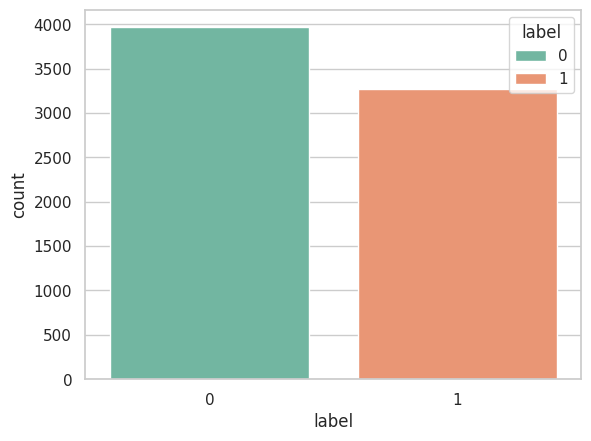

In [112]:
high_confidence_threshold = 0.99
label_map = {'CONFIRMED': 1, 'FALSE POSITIVE': 0}
df_binary = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
df_binary['label'] = df_binary['koi_disposition'].map(label_map)

candidates = df[df['koi_disposition'] == 'CANDIDATE'].copy()
pseudo_confirmed = candidates[candidates['koi_score'] >= high_confidence_threshold].copy()
pseudo_confirmed['label'] = 1

df_augmented = pd.concat([df_binary, pseudo_confirmed], ignore_index=True)
df_augmented.label.value_counts()
sns.countplot(data=df_augmented, x='label', hue='label', palette="Set2")

Como *bonus* se produce un balanceo de clases

### Otras variables


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              8054 non-null   int64  
 1   kepoi_name         8054 non-null   object 
 2   kepler_name        2730 non-null   object 
 3   koi_disposition    8054 non-null   object 
 4   koi_pdisposition   8054 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      8054 non-null   int64  
 7   koi_fpflag_ss      8054 non-null   int64  
 8   koi_fpflag_co      8054 non-null   int64  
 9   koi_fpflag_ec      8054 non-null   int64  
 10  koi_period         8054 non-null   float64
 11  koi_period_err1    7904 non-null   float64
 12  koi_period_err2    7904 non-null   float64
 13  koi_time0bk        8054 non-null   float64
 14  koi_time0bk_err1   7904 non-null   float64
 15  koi_time0bk_err2   7904 non-null   float64
 16  koi_impact         7995 

Observamos que hay un gran número de columnas. Muchas de estas variables deben ser dropeadas antes de entrenar el algoritmo.

Algunas como `koi_disposition`, `koi_pdisposition` y `koi_score` por estar directamente relacionadas con el target y como lo armamos.
Otras, las consideramos irrelevantes para el modelo por no aportar información *fisica* como las coordenadas celestes del objeto.
Además, a menos que sea necesario luego, dropearemos las columnas que representan errores de ciertas magnitudes y nos quedaremos
con los features que representan el valor medio de dicha magnitud.

Ids y nombres tambien se dropean.

Antes de dropear las columnas disposition, miramos que pasa con las variables tipo flag.

Segun la documentacion

- `koi_fpflag_nt` (Not Transit-Like Flag): <BR> 
        *A KOI whose light curve is not consistent with that of a transiting planet.*
  
- `koi_fpflag_ss` (Stellar Eclipse Flag):<BR>
        *(...) indicates that the transit-like event is most likely caused by an eclipsing binary. However, self-luminous, hot Jupiters with a visible secondary eclipse will also have this flag set, but with a disposition of PC.*

    	 
- `koi_fpflag_co` (Centroid Offset Flag):<br>
      *The source of the signal is from a nearby star (...)*

  
- `koi_fpflag_ec` (Ephemeris Match Indicates Contamination Flag): <br>
      *The KOI shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.*

Por lo que parece ser que alguna de estas seteadas a 1, es condición suficiente para falso positivo (excepto tal vez `koi_fpflag_ss`)

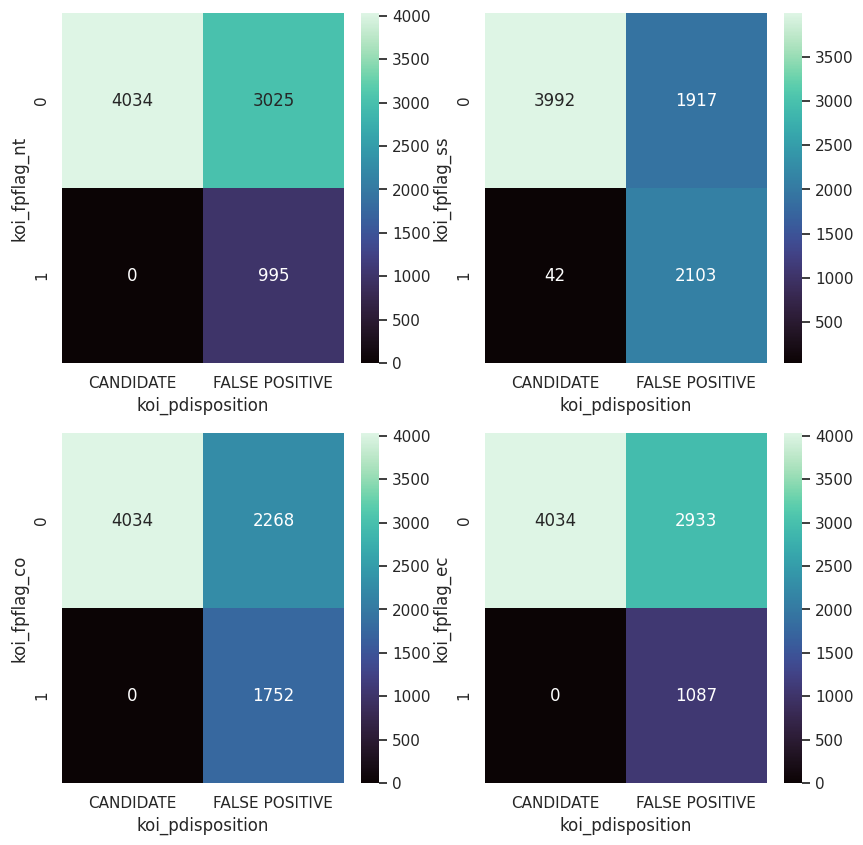

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(
    pd.crosstab( df['koi_fpflag_nt'], df['koi_pdisposition']),
    annot=True, fmt='d', cmap='mako', ax=axes[0][0]
)
sns.heatmap(
    pd.crosstab( df['koi_fpflag_ss'], df['koi_pdisposition']),
    annot=True, fmt='d', cmap='mako', ax=axes[0][1]
)
sns.heatmap(
    pd.crosstab( df['koi_fpflag_co'], df['koi_pdisposition']),
    annot=True, fmt='d', cmap='mako', ax=axes[1][0]
)
sns.heatmap(
    pd.crosstab( df['koi_fpflag_ec'], df['koi_pdisposition']),
    annot=True, fmt='d', cmap='mako', ax=axes[1][1]
)
plt.show()

En efecto, 3 de las cuatro flags son, por sí mismas, condición suficientes para detectar un falso positivo.
La cuarta, `koi_fpflag_ss`, si bien no es suficiente, practiacmente determina (44 vs 2103) un FP.
Entonces, como determinan univocamente los targets, estos features deben ser dropeados para la clasificación

In [115]:
cols_a_dropear = ['kepid',
                  'kepoi_name',
                  'kepler_name',
                  'koi_tce_delivname',
                  'koi_pdisposition',
                  'koi_disposition',
                  'koi_score',
                  'koi_fpflag_nt',
                  'koi_fpflag_ss',
                  'koi_fpflag_co',
                  'koi_fpflag_ec',                  
                  'koi_period_err1',
                  'koi_period_err2',
                  'koi_time0bk_err1',
                  'koi_time0bk_err2',
                  'koi_impact_err1',
                  'koi_impact_err2',
                  'koi_duration_err1',
                  'koi_duration_err2',
                  'koi_depth_err1',
                  'koi_depth_err2',
                  'koi_prad_err1',
                  'koi_prad_err2',
                  'koi_teq_err1',
                  'koi_teq_err2',
                  'koi_insol_err1',
                  'koi_insol_err2',
                  'koi_steff_err1',
                  'koi_steff_err2',
                  'koi_slogg_err1',
                  'koi_slogg_err2',
                  'koi_srad_err1',
                  'koi_srad_err2',
                  'koi_tce_plnt_num',
                  'ra','dec','koi_time0bk']
df = df_augmented.drop(columns=cols_a_dropear)
df.head()

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,label
0,2.470613,0.818,1.74319,14230.9,13.04,1339.0,761.46,4304.3,5820.0,4.457,0.964,11.338,1
1,2.204735,0.224,3.88864,6674.7,16.10,2048.0,4148.92,5945.9,6440.0,4.019,1.952,10.463,1
2,4.887803,0.054,2.36255,4315.8,4.82,800.0,96.67,862.3,4778.0,4.591,0.763,9.174,1
3,3.849372,0.915,2.63200,1298.6,12.94,2034.0,4055.29,132.7,6244.0,3.657,2.992,11.432,1
4,1.334101,0.153,2.10330,120.8,1.74,2169.0,5207.55,43.0,6178.0,4.106,1.580,12.161,0


Ademas, `koi_insol` y `koi_teq` estan altamente relacionadas, 
$ F = \sigma T ^ 4 $ (stefan - boltzmann)

veamos si se cumple

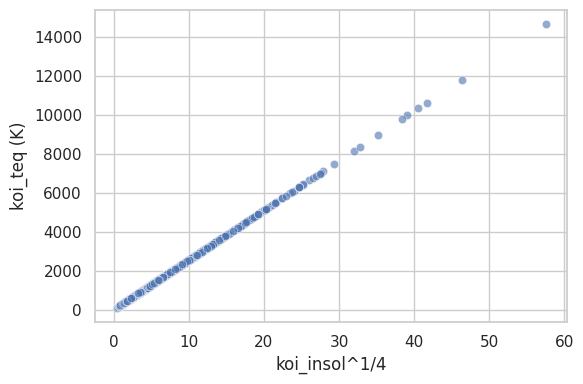

In [116]:
df_teq = df[['koi_teq', 'koi_insol']].dropna()

df_teq['insol_root4'] = df_teq['koi_insol'] ** 0.25

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_teq, x='insol_root4', y='koi_teq', alpha=0.6)
plt.xlabel("koi_insol^1/4")
plt.ylabel("koi_teq (K)")
plt.tight_layout()
plt.show()

como puede verse la relacion es proporcional entre $T \propto I^{1/4}$ por lo que podemos tirar una de las dos columnas.
Luego de mirar outliers y nulos podemos decidir cual de las dos conservar

### Nulos

Chequeo si hay valores nulos

In [117]:
print("\nCantidad de NaN por columna:")
print(df.isna().sum())


Cantidad de NaN por columna:
koi_period        0
koi_impact       57
koi_duration      0
koi_depth        57
koi_prad         57
koi_teq          57
koi_insol        57
koi_model_snr    57
koi_steff        57
koi_slogg        57
koi_srad         57
koi_kepmag        1
label             0
dtype: int64


In [118]:
filas_con_nan = df[df.isna().any(axis=1)]
print(f"Total de filas con NaN: {len(filas_con_nan)}")

Total de filas con NaN: 58


Ya que se trata de muy pocas filas podemos dropearlas

In [119]:
df = df.dropna()

Ademas quedaba pendiente dropear alguna de las columnas `teq` o `insol`. Como tienen la misma cantidad de faltantes, dropeamos cualquiera.

Por ser mas inmediata la interpretación de la temperatura de equilibrio en Kelvin, nos quedamos con esa

In [120]:
df = df.drop(columns='koi_insol', axis=1)

### Outliers

Miramos un poco la distribución de los datos para detectar outliers.

In [121]:
check_outliers_cols = ['koi_period',
                       'koi_impact',
                       'koi_duration',
                       'koi_depth',
                       'koi_prad',        
                       'koi_teq', 
                       'koi_model_snr', 
                       'koi_steff',
                       'koi_slogg',
                       'koi_srad', 
                       'koi_kepmag']
df[check_outliers_cols].describe(percentiles=[.5, .9, .99])

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag
count,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000
mean,34.238187,0.636361,5.394739,29314.309242,30.210885,1166.647616,321.252328,5692.561054,4.319137,1.694009,14.306508
std,82.454601,0.793862,6.494177,89139.453678,328.810640,856.278844,880.951720,800.799141,0.424739,6.026202,1.382929
min,0.259820,0.000000,0.052000,0.000000,0.080000,92.000000,0.000000,2661.000000,0.047000,0.116000,6.966000
50%,7.207947,0.608000,3.730800,507.050000,2.640000,955.000000,32.300000,5759.000000,4.440000,0.996000,14.557000
90%,77.220224,1.194000,9.897100,82649.420000,59.227000,2111.100000,900.000000,6403.700000,4.614000,2.122400,15.767000
99%,420.232692,1.446560,30.699400,436677.720000,330.961300,4197.890000,4706.061000,8220.210000,4.800000,13.466150,17.049240
max,1071.232624,25.224000,138.540000,921671.000000,26042.900000,14667.000000,9054.700000,15896.000000,5.283000,229.908000,20.003000


Una a una:

| Variable        | Observación                                                                    | Posible acción                                                                |
| --------------- | ------------------------------------------------------------------------------ | ----------------------------------------------------------------------------- |
| `koi_period`    | muy sesgada a la derecha -  valores hasta 1071 días son razonables               | conservar, aplicar `log1p()` o cortar en el 99%   |
| `koi_impact`    | escala \[0–2] esperada - hay valores extremos hasta 25                     | recortar valores >2, podrían ser inválidos físicamente (no hay tránsito)  |
| `koi_duration`  | sesgo fuerte a la derecha - dura hasta 138 horas                                | recortar en 99% (~30h)            |
| `koi_depth`     | extremadamente sesgada - máximo ~921,000 ppm                                   | aplicar `log1p()` o cortar al 99% (~436,000).            |
| `koi_prad`      | hay valores físicamente imposibles (hasta 26,000 radios terrestres)            | limpiar >100 radios terrestres              |
| `koi_teq`       | Máximos esperados \~4000–5000 K, algunos hasta 14,000 |  cortar al 99%|
| `koi_model_snr` | SNR extremo (>9000), pero esperable en buenos candidatos                       | conservar, aplicar `log1p()`si es necesario |
| `koi_steff`     | temp. estelar. Máximo 15,896 K. valores razonables            | conservar |
| `koi_slogg`     | Distribución acotada, sin outliers fuertes                                     | Sin acción necesaria.                                                       |
| `koi_srad`      | valores de hasta 229 radios solares; valores razonables para gigantes rojas. muy sesgada                    | Conservar o recortar 99%                               |
| `koi_kepmag`    | Magnitud aparente. A mayor valor, menor brillo. Hasta \~20                     | Conservar|


In [122]:
def check_and_remove_outliers(df, column, percentile=99, remove=False, verbose=True):
    cutoff = np.percentile(df[column].dropna(), percentile)
    outliers = df[column] > cutoff
    num_outliers = outliers.sum()

    if verbose:
        print(f"Column: {column}")
        print(f"  Percentile ({percentile}%): {cutoff:.4f}")
        print(f"  Number of outliers: {num_outliers} ({num_outliers / len(df) * 100:.2f}%)")

    if remove:
        return df[~outliers].copy()
    else:
        return num_outliers


In [123]:
# removemos el 1% superior de planet radius
df = check_and_remove_outliers(df, 'koi_prad', percentile=99, remove=True)

Column: koi_prad
  Percentile (99%): 330.9613
  Number of outliers: 72 (1.00%)


In [125]:
# removemos columnas con parametros de impacto >2 (transito no visible)
df = df[df['koi_impact'] <= 2]

/tmp/ipykernel_1022436/1148857061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_prad'] = np.log1p(df['koi_prad'])  # log1p to avoid log(0) if needed


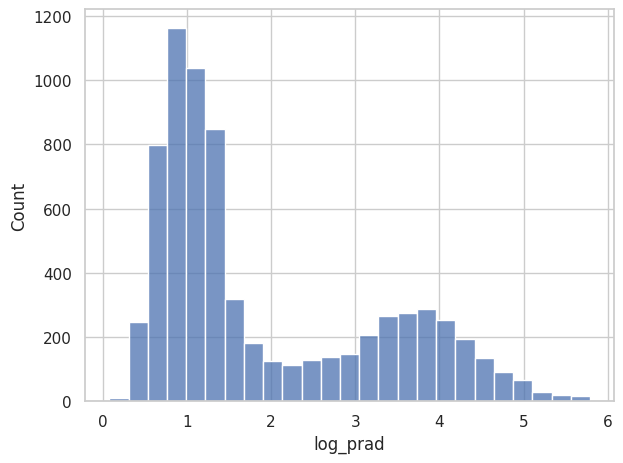

In [129]:

df['log_prad'] = np.log1p(df['koi_prad'])

sns.histplot(data=df, x='log_prad')
plt.tight_layout()
plt.show()


SelectKbest

In [69]:
# Prepare data
X = df.drop(columns=['label'])
y = df['label']

# Scale data for chi2
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Feature selection with chi2
k = 10
chi2_selector = SelectKBest(chi2, k=k)
chi2_selector.fit(X_scaled, y)

# Feature selection with f_classif
f_selector = SelectKBest(f_classif, k=k)
f_selector.fit(X, y)

# Display results
print("Top features by chi2:")
for feature, score in zip(X.columns[chi2_selector.get_support()], chi2_selector.scores_[chi2_selector.get_support()]):
    print(f"{feature:20} {score:.2f}")

print("\nTop features by f_classif:")
for feature, score in zip(X.columns[f_selector.get_support()], f_selector.scores_[f_selector.get_support()]):
    print(f"{feature:20} {score:.2f}")

Top features by chi2:
koi_period           8.23
koi_impact           12.38
koi_duration         12.00
koi_depth            176.29
koi_prad             5.39
koi_teq              32.89
koi_insol            3.10
koi_model_snr        125.61
koi_steff            5.31
koi_srad             5.01

Top features by f_classif:
koi_period           44.29
koi_impact           329.87
koi_duration         216.87
koi_depth            653.99
koi_prad             39.35
koi_teq              778.81
koi_model_snr        503.82
koi_steff            348.36
koi_slogg            203.03
koi_srad             50.37


In [70]:
df

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,label
0,2.470613,0.818,1.74319,14230.9,13.04,1339.0,761.46,4304.3,5820.0,4.457,0.964,11.338,1
1,2.204735,0.224,3.88864,6674.7,16.10,2048.0,4148.92,5945.9,6440.0,4.019,1.952,10.463,1
2,4.887803,0.054,2.36255,4315.8,4.82,800.0,96.67,862.3,4778.0,4.591,0.763,9.174,1
3,3.849372,0.915,2.63200,1298.6,12.94,2034.0,4055.29,132.7,6244.0,3.657,2.992,11.432,1
4,1.334101,0.153,2.10330,120.8,1.74,2169.0,5207.55,43.0,6178.0,4.106,1.580,12.161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,9.910579,0.813,5.94500,99.5,1.19,922.0,170.47,9.2,6214.0,4.442,1.076,14.863,1
7228,43.908805,0.272,6.26500,297.8,7.33,885.0,144.75,13.7,5216.0,3.402,4.303,13.589,1
7229,0.719741,0.275,2.62800,32.2,0.57,2074.0,4398.76,6.5,6014.0,4.486,0.993,8.777,1
7230,9.464041,0.048,6.99900,209.9,1.28,839.0,117.23,9.4,5968.0,4.534,0.881,15.807,1


## Implementacion de algoritmos de ML

Random Forest sin Flags


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       710
           1       0.85      0.92      0.88       653

    accuracy                           0.88      1363
   macro avg       0.89      0.89      0.88      1363
weighted avg       0.89      0.88      0.88      1363

ROC AUC: 0.9444449237538555


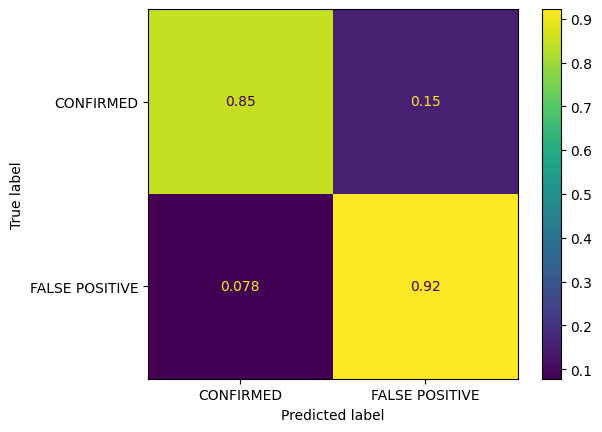

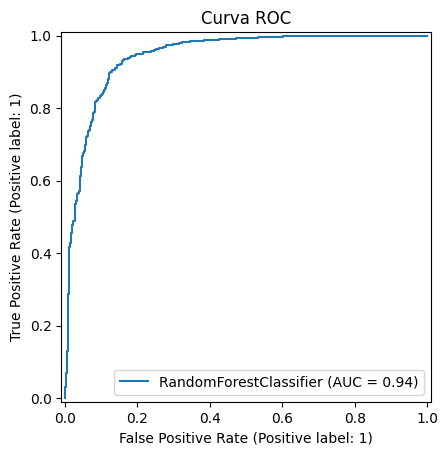

/tmp/ipykernel_1022436/1821839418.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


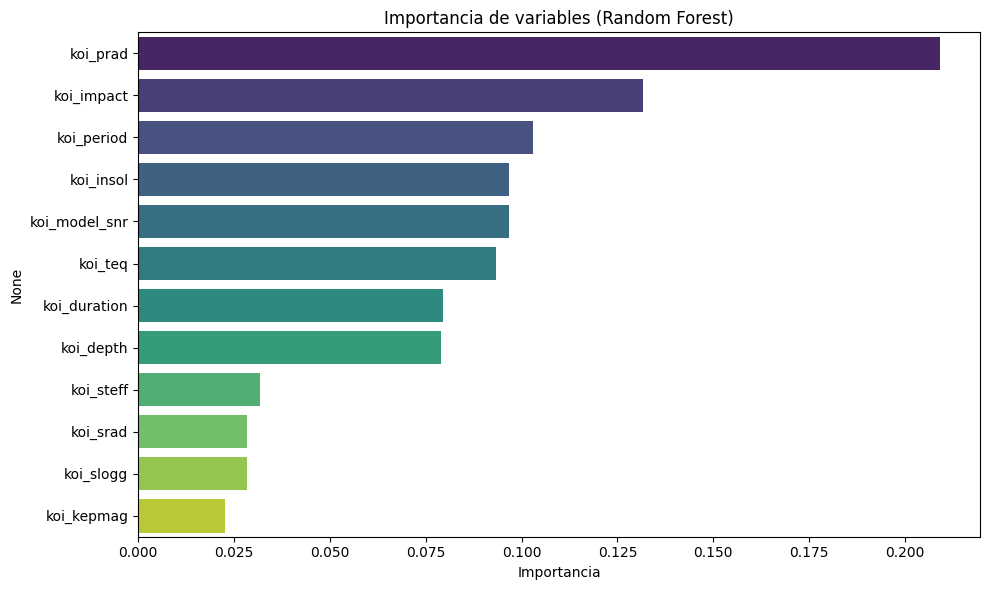

In [32]:


# Dropear flags
cols_to_drop = [
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')


# Separar features y label

X = df.drop(columns=['label'])
y = df['label']


# Dividir train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Entrenar modelo

clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

# Evaluación

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['CONFIRMED', 'FALSE POSITIVE'])
disp.plot(xticks_rotation='horizontal')

# Curva ROC
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC")
plt.show()

# Importancia de variables
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Importancia de variables (Random Forest)")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


In [20]:
df = check_and_remove_outliers(df, 'koi_depth', remove=True)

Column: koi_depth
  Percentile (95%): 220693.4500
  Number of outliers: 359 (5.00%)


In [21]:
df.label.value_counts()

label
0    3552
1    3263
Name: count, dtype: int64